In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [75]:
df = pd.read_csv("orders.csv")

df['DateTime'] = pd.to_datetime(df['DateTime_CartFinalize'])
df['DateTime']

0        2015-10-15 08:50:56
1        2018-02-11 00:29:26
2        2016-06-14 00:30:08
3        2018-09-03 14:37:19
4        2016-05-21 11:51:02
                 ...        
199995   2018-04-03 12:07:01
199996   2016-07-09 19:14:09
199997   2017-03-08 23:47:06
199998   2017-02-08 14:59:39
199999   2017-06-17 10:08:06
Name: DateTime, Length: 200000, dtype: datetime64[ns]

In [76]:
df.columns

Index(['ID_Order', 'ID_Customer', 'ID_Item', 'DateTime_CartFinalize',
       'Amount_Gross_Order', 'city_name_fa', 'Quantity_item', 'DateTime'],
      dtype='object')

### تعداد فروش کلی به ازای هرروز

In [77]:
daily_sales = df.groupby(df['DateTime'].dt.date)['Quantity_item'].sum().reset_index()
daily_sales.columns = ['DateTime' , 'Total_Quantity_item']
daily_sales

,DateTime,Total_Quantity_item
0,2013-09-27,3.0
1,2013-09-28,2.0
2,2013-09-29,1.0
3,2013-09-30,1.0
4,2013-10-04,4.0
...,...,...
1885,2018-12-07,242.0
1886,2018-12-08,289.0
1887,2018-12-09,323.0
1888,2018-12-10,307.0


### تعداد فروش به ازای هر شهر

In [78]:

sales_by_city_date = df.groupby([df['DateTime'].dt.date, 'city_name_fa'])['Quantity_item'].sum().reset_index()
sales_by_city_date

,DateTime,city_name_fa,Quantity_item
0,2013-09-27,تهران,1.0
1,2013-09-27,شهرکرد,1.0
2,2013-09-27,قم,1.0
3,2013-09-28,زنجان,2.0
4,2013-09-29,رشت,1.0
...,...,...,...
56307,2018-12-11,شیراز,2.0
56308,2018-12-11,قزوین,1.0
56309,2018-12-11,قم,7.0
56310,2018-12-11,کامیاران,1.0


In [79]:
daily_sales["DateTime"]

0       2013-09-27
1       2013-09-28
2       2013-09-29
3       2013-09-30
4       2013-10-04
           ...    
1885    2018-12-07
1886    2018-12-08
1887    2018-12-09
1888    2018-12-10
1889    2018-12-11
Name: DateTime, Length: 1890, dtype: object

In [80]:
daily_sales.to_csv("Daily_Sales_Quantity_Date.csv", index=False)

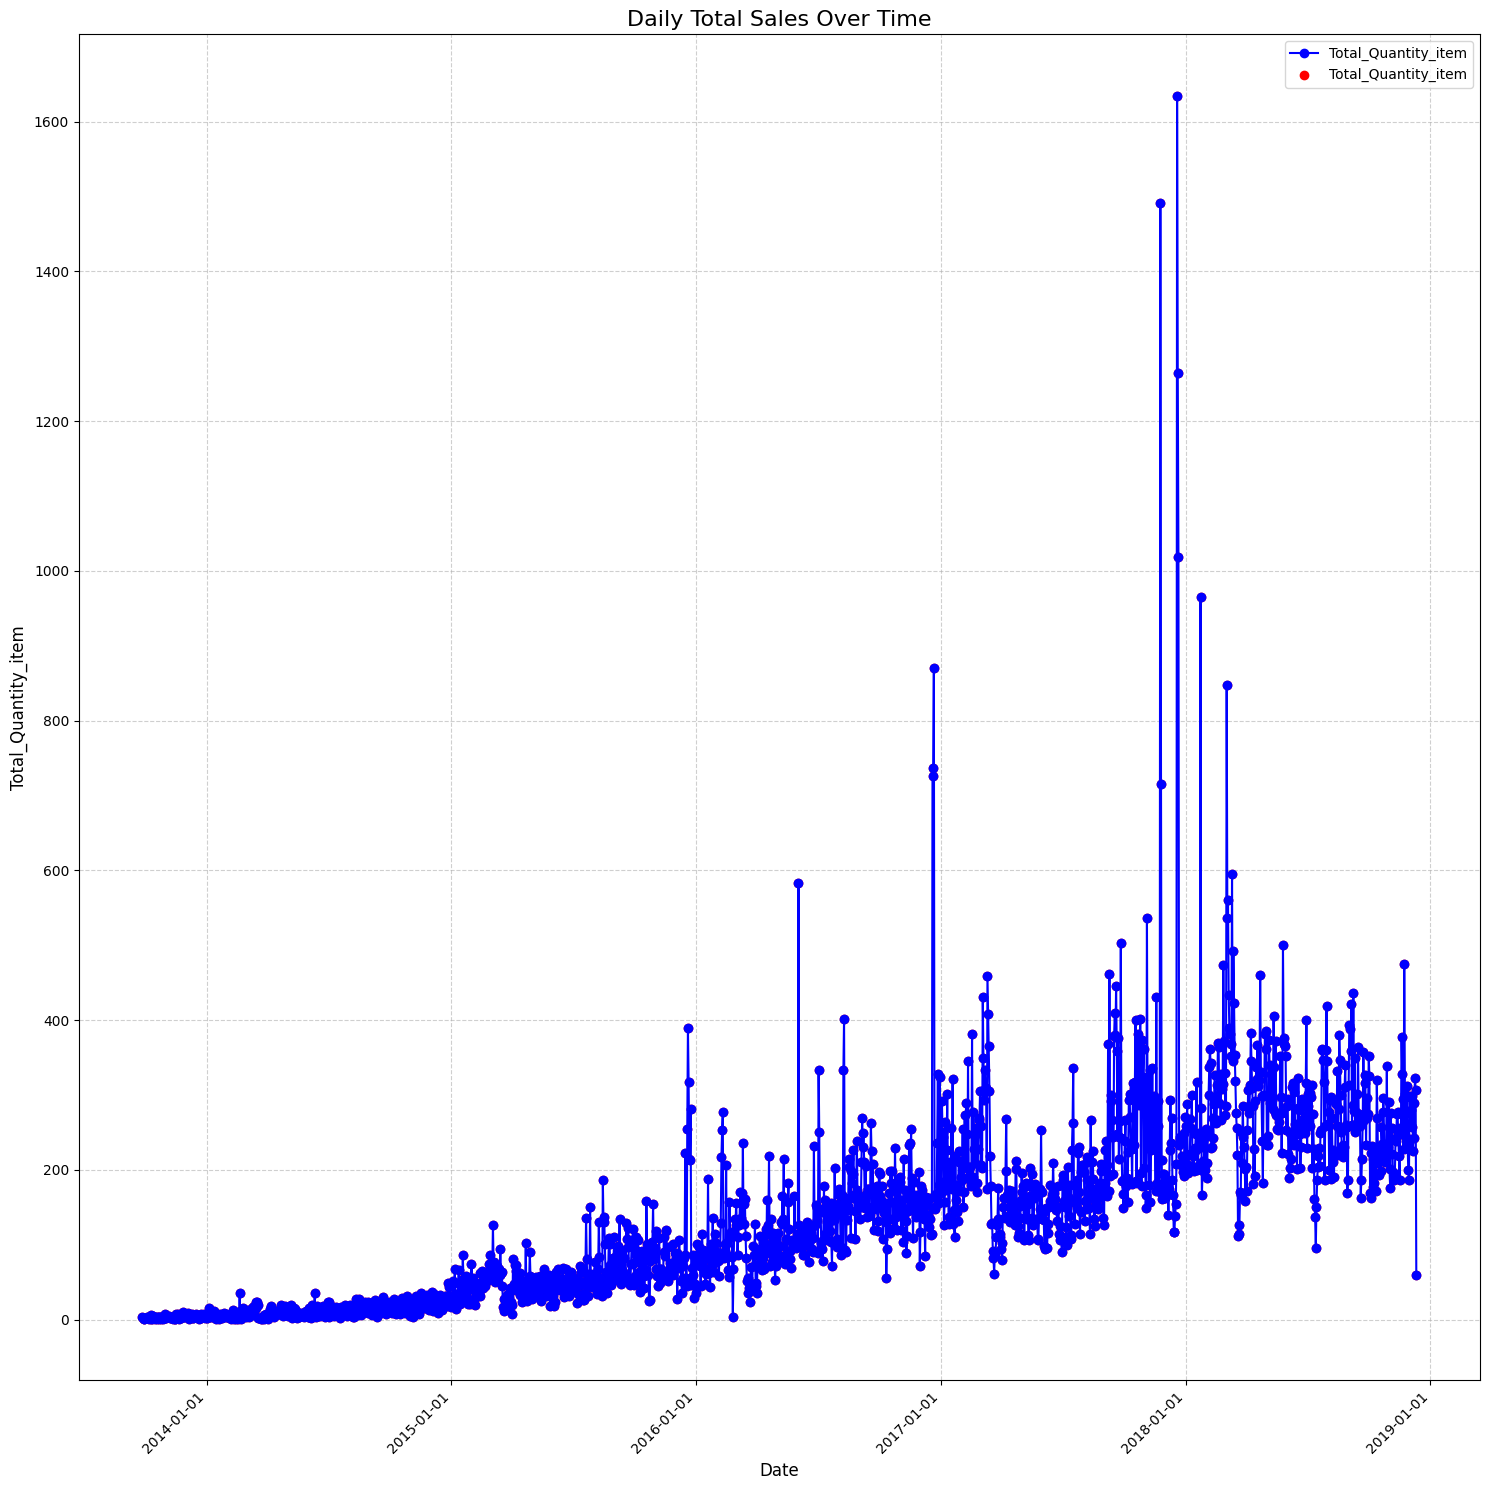

In [81]:
plt.figure(figsize=(15, 15))

plt.plot(daily_sales['DateTime'], daily_sales['Total_Quantity_item'], label='Total_Quantity_item', color='blue', marker='o', linestyle='-')
plt.scatter(daily_sales['DateTime'], daily_sales['Total_Quantity_item'], label='Total_Quantity_item', color='red', marker='o',)

plt.title('Daily Total Sales Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total_Quantity_item', fontsize=12)

ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # فرمت تاریخ: سال-ماه-روز
ax.xaxis.set_major_locator(mdates.AutoDateLocator()) # تنظیم خودکار محل قرارگیری تاریخ‌ها
plt.xticks(rotation=45, ha='right') # چرخش برچسب‌ها برای جلوگیری از همپوشانی

plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

In [82]:
daily_sales.describe()

,Total_Quantity_item
count,1890.000000
mean,133.462963
std,129.593243
min,1.000000
25%,29.000000
50%,108.500000
75%,203.000000
max,1635.000000


### Ouliers Detection

#### IQR (Interquartile Range)

In [83]:
Q1 = np.quantile(daily_sales['Total_Quantity_item'], 0.25)
Q2 = np.quantile(daily_sales['Total_Quantity_item'], 0.50)
Q3 = np.quantile(daily_sales['Total_Quantity_item'], 0.75)


In [84]:
total_quantity = daily_sales["Total_Quantity_item"].values

In [85]:
total_quantity[total_quantity < Q1].size

466

In [86]:
total_quantity[(total_quantity >= Q1) & (total_quantity < Q2)].size

479

In [87]:
total_quantity[(total_quantity >= Q2) & (total_quantity < Q3)].size

468

In [88]:
total_quantity[total_quantity >= Q3].size

477

In [89]:
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR
lower_bond = 0 # Lower Bound can not be a negative number

In [90]:
outliers_low = daily_sales[total_quantity < lower_bound]
outliers_high = daily_sales[total_quantity > upper_bound]
outliers_high.value_counts().sum()

np.int64(20)

In [91]:
daily_sales["DateTime"].value_counts().sum()

np.int64(1890)

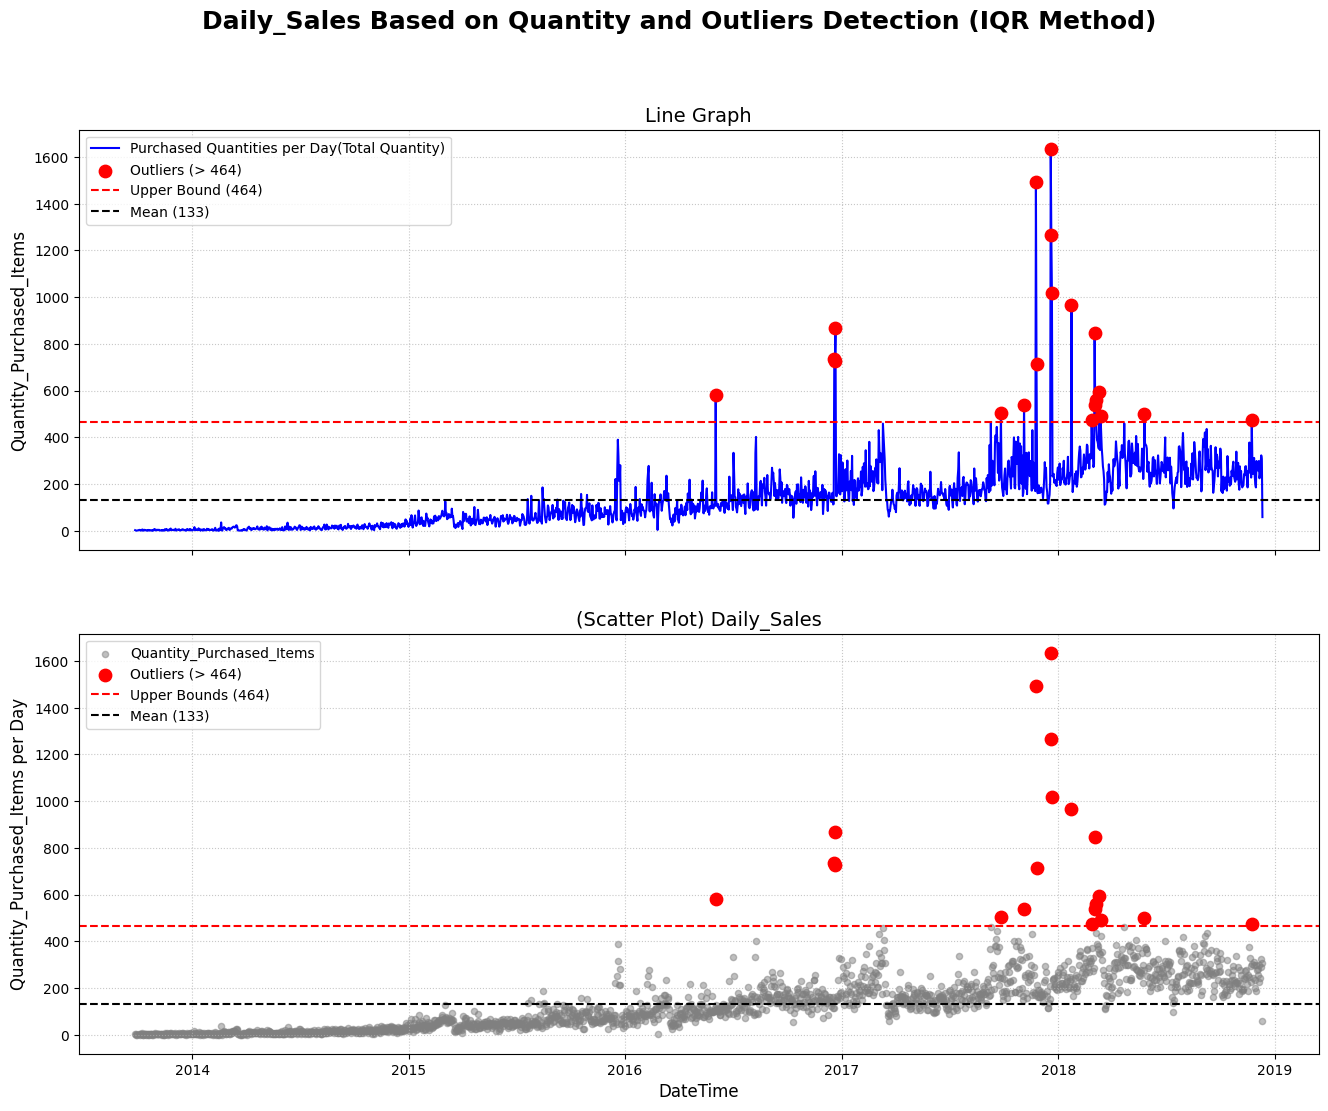

In [92]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 12), sharex=True)
fig.suptitle('Daily_Sales Based on Quantity and Outliers Detection (IQR Method)', fontsize=18, fontweight='bold')


axes[0].plot(daily_sales['DateTime'], daily_sales['Total_Quantity_item'], label='Purchased Quantities per Day(Total Quantity)', color='blue', linewidth=1.5)
axes[0].scatter(outliers_high['DateTime'], outliers_high['Total_Quantity_item'],
                color='red', label=f'Outliers (> {upper_bound:.0f})', s=80, zorder=5)

axes[0].axhline(upper_bound, color='red', linestyle='--', linewidth=1.5, label=f'Upper Bound ({upper_bound:.0f})')
axes[0].axhline(total_quantity.mean() , color='black', linestyle='--', linewidth=1.5, label=f'Mean ({total_quantity.mean():.0f})')

axes[0].set_title('Line Graph', fontsize=14)
axes[0].set_ylabel('Quantity_Purchased_Items', fontsize=12)

axes[0].legend(loc='upper left')
axes[0].grid(True, linestyle=':', alpha=0.7)


axes[1].scatter(daily_sales['DateTime'], daily_sales['Total_Quantity_item'], label='Quantity_Purchased_Items', color='gray', alpha=0.5, s=20)
axes[1].scatter(outliers_high['DateTime'], outliers_high['Total_Quantity_item'],
                color='red', label=f'Outliers (> {upper_bound:.0f})', s=80, zorder=5)

axes[1].axhline(upper_bound, color='red', linestyle='--', linewidth=1.5, label=f'Upper Bounds ({upper_bound:.0f})')
axes[1].axhline(total_quantity.mean() , color='black', linestyle='--', linewidth=1.5, label=f'Mean ({total_quantity.mean():.0f})')

axes[1].set_title('(Scatter Plot) Daily_Sales', fontsize=14)

axes[1].set_xlabel('DateTime', fontsize=12)
axes[1].set_ylabel('Quantity_Purchased_Items per Day', fontsize=12)

axes[1].legend(loc='upper left')
axes[1].grid(True, linestyle=':', alpha=0.7)


#### Outliers Based On the Date (IQR-Based) (Total 20)

In [93]:
outliers_high['DateTime']

967     2016-06-02
1167    2016-12-19
1168    2016-12-20
1169    2016-12-21
1448    2017-09-26
1487    2017-11-04
1507    2017-11-24
1508    2017-11-25
1532    2017-12-19
1533    2017-12-20
1534    2017-12-21
1567    2018-01-23
1601    2018-02-26
1606    2018-03-03
1607    2018-03-04
1608    2018-03-05
1614    2018-03-11
1616    2018-03-13
1690    2018-05-26
1871    2018-11-23
Name: DateTime, dtype: object

##### Total Ouliers Based On Date

In [94]:
sorted_outliers = outliers_high.sort_values(by='Total_Quantity_item', ascending=False)
sorted_outliers

,DateTime,Total_Quantity_item
1532,2017-12-19,1635.0
1507,2017-11-24,1492.0
1533,2017-12-20,1265.0
1534,2017-12-21,1018.0
1567,2018-01-23,965.0
1169,2016-12-21,870.0
1606,2018-03-03,848.0
1167,2016-12-19,737.0
1168,2016-12-20,726.0
1508,2017-11-25,716.0


##### 5 Days with the most Excessive Outliers

In [95]:
sorted_outliers['DateTime'].head(5)

1532    2017-12-19
1507    2017-11-24
1533    2017-12-20
1534    2017-12-21
1567    2018-01-23
Name: DateTime, dtype: object

##### 5 months with the Lightest Outliers


In [96]:
sorted_outliers['DateTime'].tail(5)

1448    2017-09-26
1690    2018-05-26
1616    2018-03-13
1871    2018-11-23
1601    2018-02-26
Name: DateTime, dtype: object

#### Mean +_ std

In [97]:
mean = total_quantity.mean()
std = total_quantity.std()

upper_bound = mean + 3 * std
lower_bound = mean - 3 * std
lower_bond = 0 # Quantity != -num

In [98]:
outliers_low = daily_sales[total_quantity < lower_bound]
outliers_high = daily_sales[total_quantity > upper_bound]
outliers_high.value_counts().sum()

np.int64(15)

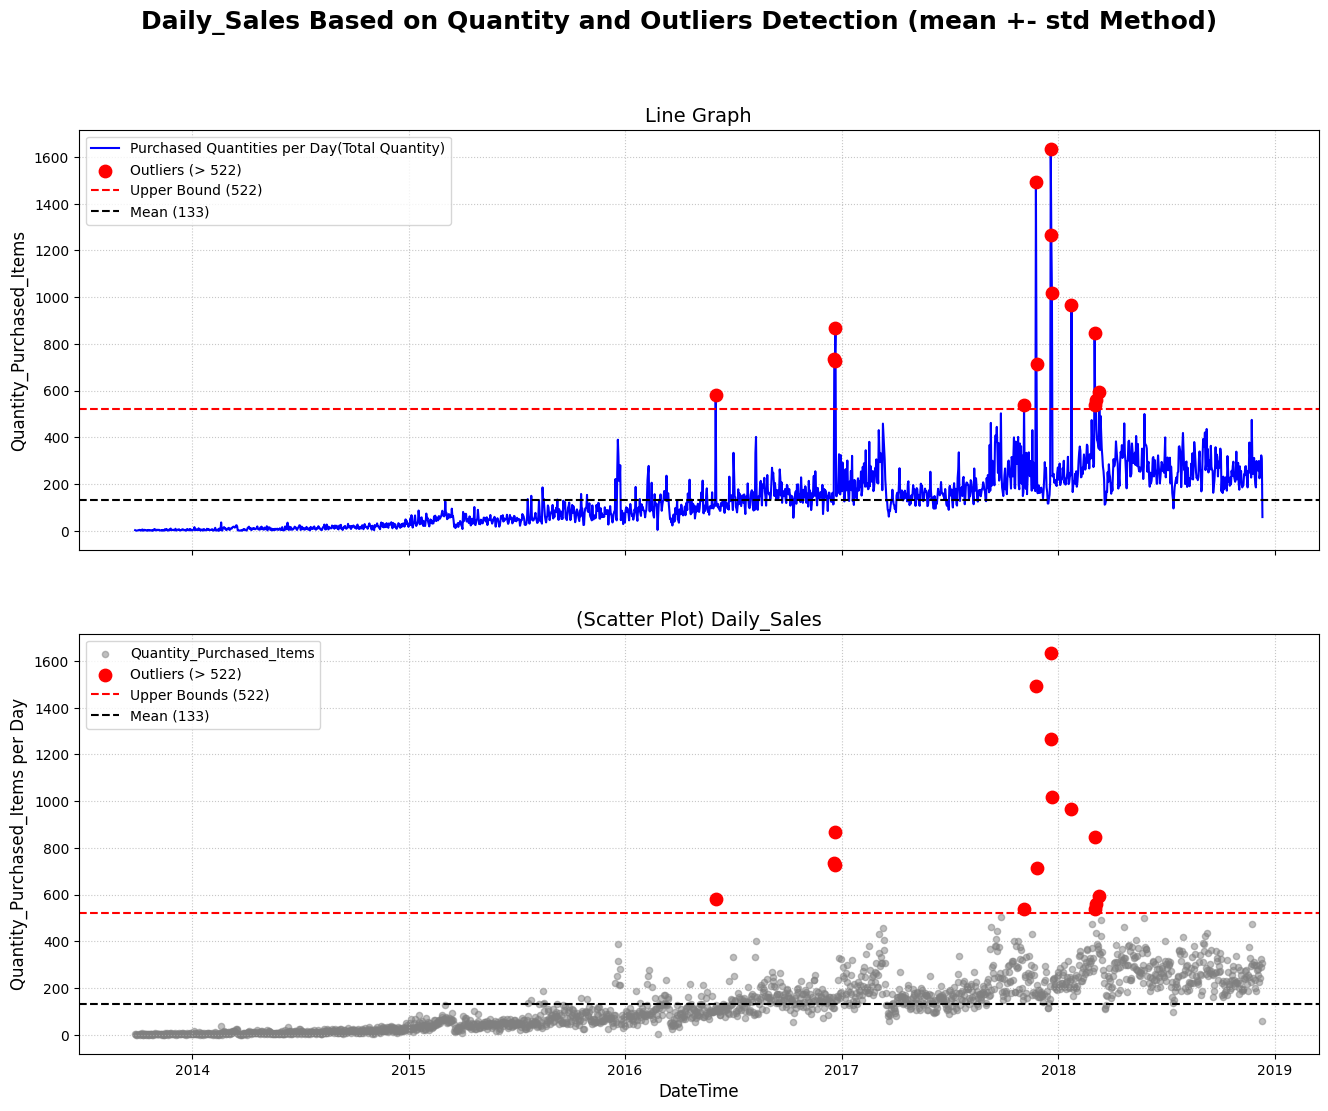

In [99]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 12), sharex=True)

fig.suptitle('Daily_Sales Based on Quantity and Outliers Detection (mean +- std Method)', fontsize=18, fontweight='bold')

axes[0].plot(daily_sales['DateTime'], daily_sales['Total_Quantity_item'], label='Purchased Quantities per Day(Total Quantity)', color='blue', linewidth=1.5)
axes[0].scatter(outliers_high['DateTime'], outliers_high['Total_Quantity_item'],
                color='red', label=f'Outliers (> {upper_bound:.0f})', s=80, zorder=5)

axes[0].axhline(upper_bound, color='red', linestyle='--', linewidth=1.5, label=f'Upper Bound ({upper_bound:.0f})')
axes[0].axhline(mean , color='black', linestyle='--', linewidth=1.5, label=f'Mean ({mean:.0f})')

axes[0].set_title('Line Graph', fontsize=14)

axes[0].set_ylabel('Quantity_Purchased_Items', fontsize=12)

axes[0].legend(loc='upper left')
axes[0].grid(True, linestyle=':', alpha=0.7)


axes[1].scatter(daily_sales['DateTime'], daily_sales['Total_Quantity_item'], label='Quantity_Purchased_Items', color='gray', alpha=0.5, s=20)
axes[1].scatter(outliers_high['DateTime'], outliers_high['Total_Quantity_item'],
                color='red', label=f'Outliers (> {upper_bound:.0f})', s=80, zorder=5)

axes[1].axhline(upper_bound, color='red', linestyle='--', linewidth=1.5, label=f'Upper Bounds ({upper_bound:.0f})')
axes[1].axhline(mean , color='black', linestyle='--', linewidth=1.5, label=f'Mean ({mean:.0f})')

axes[1].set_title('(Scatter Plot) Daily_Sales', fontsize=14)

axes[1].set_xlabel('DateTime', fontsize=12)
axes[1].set_ylabel('Quantity_Purchased_Items per Day', fontsize=12)

axes[1].legend(loc='upper left')
axes[1].grid(True, linestyle=':', alpha=0.7)



#### Outliers Based On the Date (mean+-std)

##### Total Outliers Based on Date (Total 15)

In [100]:
outliers_high['DateTime']

967     2016-06-02
1167    2016-12-19
1168    2016-12-20
1169    2016-12-21
1487    2017-11-04
1507    2017-11-24
1508    2017-11-25
1532    2017-12-19
1533    2017-12-20
1534    2017-12-21
1567    2018-01-23
1606    2018-03-03
1607    2018-03-04
1608    2018-03-05
1614    2018-03-11
Name: DateTime, dtype: object

In [101]:
sorted_outliers = outliers_high.sort_values(by='Total_Quantity_item', ascending=False)
sorted_outliers

,DateTime,Total_Quantity_item
1532,2017-12-19,1635.0
1507,2017-11-24,1492.0
1533,2017-12-20,1265.0
1534,2017-12-21,1018.0
1567,2018-01-23,965.0
1169,2016-12-21,870.0
1606,2018-03-03,848.0
1167,2016-12-19,737.0
1168,2016-12-20,726.0
1508,2017-11-25,716.0


##### 5 Days with the most Excessive Outliers

In [102]:
sorted_outliers['DateTime'].head(5)

1532    2017-12-19
1507    2017-11-24
1533    2017-12-20
1534    2017-12-21
1567    2018-01-23
Name: DateTime, dtype: object

##### 5 Days with the Lightest Outliers

In [103]:
sorted_outliers['DateTime'].tail(5)

1614    2018-03-11
967     2016-06-02
1608    2018-03-05
1487    2017-11-04
1607    2018-03-04
Name: DateTime, dtype: object

#### Violin and Box Plot

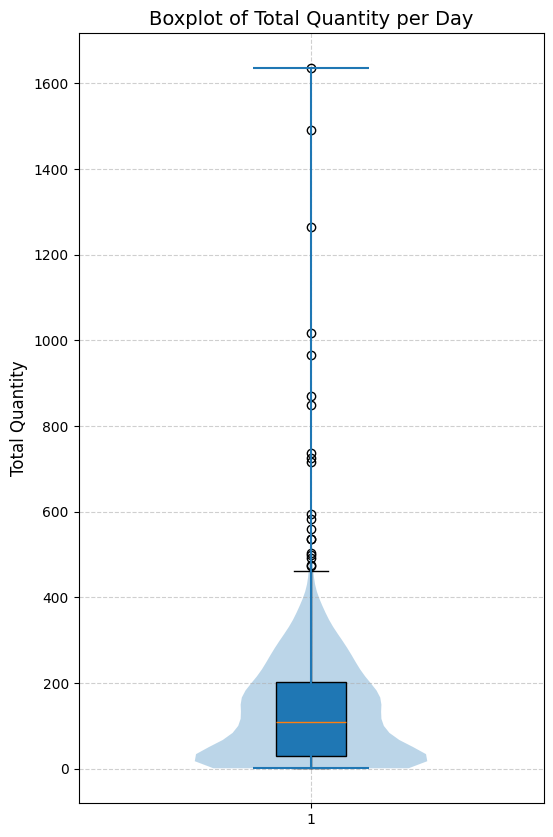

In [104]:
plt.figure(figsize=(6, 10))

plt.boxplot(daily_sales["Total_Quantity_item"], vert=True, patch_artist=True)
plt.violinplot(daily_sales["Total_Quantity_item"], vert=True)

plt.title("Boxplot of Total Quantity per Day", fontsize=14)
plt.ylabel("Total Quantity", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

